# Model 3: Specify the external_CS and external_CTX populations to represent stimuli seen in fear generalization experiments

In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif')

## Experiment 1: Fear generalization to similar CS
The CS will be a 1-dimensional input, corresponding to auditory tone, circle size, or greyscale value. This CS will be represented by "external_CS" using neurons with bell-shaped tuning curves. This is achieved by mapping the 1D-CS (x) into a 2D space by taking [cos(x), sin(x)], and projecting this value into "external_CS", whose encoders will be distributed around the unit circle.

Fear conditioning will proceed as normal: the CS (a particular value of x) will be paired with the US in an arbitrary context. To test generalization, we will then present a variety of novel CSs (CSg, values of x) without the US, then plot the magnitude of the fear response as a function of the similarity between CS+ and CSg.

We will use Model 2. We will turn off safety learning to avoid extinction while repeatedly presenting different CSg in CTX+, but we will leave fear context learning on to establish baseline levels of freezing.

In [16]:
class Inputs():
    def __init__(self, nCS=10, nCTX=1, dim_CS=2, dim_CTX=2, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = nengo.dists.UniformHypersphere(surface=True)
        self.dim_CS = dim_CS
        self.dim_CTX = dim_CTX
        self.nCS = nCS
        self.nCTX = nCTX
        self.CS = np.zeros((self.dim_CS))
        self.US = 0
        self.CTX = np.zeros((self.dim_CTX))
        self.CSs = self.sampler.sample(nCS, dim_CS, rng=self.rng)
        self.CTXs = self.sampler.sample(nCTX, dim_CTX, rng=self.rng)
    def get_CS(self, t):
        applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
        return self.CS if applied else np.zeros((self.dim_CS))
    def get_CTX(self, t):
        return self.CTX
    def get_US(self, t):
        applied = True if t%2>1 else False # 1s of no input, 1s of US input 
        return self.US if applied else 0

In [62]:
def build_network_CS_generalization(
        seed = 0,
        learning_rate = 1e-4,
        dt = 0.001,
        nNeurons = 100,
        dim_CS = 2,
        dim_CTX = 10,
        nCS = 10,
    ):

    rng = np.random.RandomState(seed=seed)
    sampler = nengo.dists.UniformHypersphere(surface=True)
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.01
    net.config[nengo.Probe].synapse = 0.01
    net.inputs = Inputs(nCS=nCS, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=1, seed=seed)
    intercepts_pos = nengo.dists.Uniform(0, 1)
    encoders_pos = nengo.dists.Choice([[1]])
    encoders_CS = sampler.sample(dim_CS*nNeurons, dim_CS, rng=rng)  # 2D encoders distribted around unit circle
    dInh = -2e0*np.ones((nNeurons, 1))
    
    with net:
        # inputs and outputs
        CS = nengo.Node(lambda t, x: net.inputs.get_CS(t), size_in=2)
        US = nengo.Node(lambda t, x: net.inputs.get_US(t), size_in=2)
        CTX = nengo.Node(lambda t, x: net.inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
        bias = nengo.Node(lambda t: 0.5)
        # external ensembles
        external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, encoders=encoders_CS)
        external_US = nengo.Ensemble(nNeurons, 1)
        external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX)
        # amygdala ensembles
        LA_pyr_CS = nengo.Ensemble(nNeurons, 1)  # [CS]
        LA_pyr_US = nengo.Ensemble(nNeurons, 1)  # [US]
        LA_inh_CS = nengo.Ensemble(nNeurons, 1)  # [CS]
        LA_inh_US = nengo.Ensemble(nNeurons, 1)  # [US]
        CeL_on = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [CS]
        CeL_off = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [bias-CS]
        CeM = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        BLA_pyr = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, CTX]
        BLA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
        # error ensembles
        error_LA = nengo.Ensemble(nNeurons, 1)
        error_CeL = nengo.Ensemble(nNeurons, 1)
        error_BLA_safe = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        error_BLA_fear = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        # external connections
        nengo.Connection(CS, external_CS, synapse=None)
        nengo.Connection(US, external_US, synapse=None)
        nengo.Connection(external_CS, LA_inh_CS, function=lambda x: np.sum(np.square(x)))  # any CS present
        nengo.Connection(external_US, LA_inh_US)
        nengo.Connection(external_US, LA_pyr_US)
        nengo.Connection(bias, CeL_off, transform=2)
        nengo.Connection(bias, CeM)
        nengo.Connection(CTX, external_CTX, synapse=None)
        # internal connections
        nengo.Connection(CeL_on, CeL_off, transform=-1)
        nengo.Connection(CeL_off, CeM, transform=-1)
        nengo.Connection(LA_pyr_CS, BLA_pyr[0])  # communicate [CS]
        nengo.Connection(LA_pyr_US, BLA_pyr[1])  # communicate [US]
        nengo.Connection(BLA_pyr[:2], BLA_inh)  # communicate [CS,US]
        nengo.Connection(BLA_pyr[0], CeM, transform=0.3)  # CS response added to freeze response
        nengo.Connection(BLA_pyr[2], CeM, transform=1.0)  # CTX response added to freeze response
        # learned connections
        conditioning = nengo.Connection(external_CS, LA_pyr_CS, function=lambda x: 0, learning_rule_type=nengo.PES(learning_rate))
        transmission = nengo.Connection(LA_pyr_CS, CeL_on, function=lambda x: 0, learning_rule_type=nengo.PES(learning_rate))
        extinction = nengo.Connection(external_CTX, BLA_pyr[2], function=lambda x: 0, learning_rule_type=nengo.PES(0.1*learning_rate))
        # error connections
        nengo.Connection(LA_pyr_US, error_LA, transform=+1)  # US
        nengo.Connection(LA_pyr_CS, error_LA, transform=-1)  # -CS response
        nengo.Connection(LA_pyr_CS, error_CeL, transform=+1)  # LA_pyr_CS response
        nengo.Connection(CeL_on, error_CeL, transform=-1)  # -CeL_on CS response
        nengo.Connection(BLA_pyr, error_BLA_safe, function=lambda x: x[0]+x[2])  # CS response + (-) CTX response
        nengo.Connection(BLA_pyr, error_BLA_fear, function=lambda x: x[1]-x[2])   # US response - CTX response
        # error gating
        nengo.Connection(LA_inh_US, error_LA.neurons, transform=-dInh)  # inhibit if only CS present
        nengo.Connection(LA_inh_CS, error_LA.neurons, transform=+dInh)  # inhibit if only CS present
        nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: 1-x[0]+x[1], transform=dInh)  # inhibit by default; release if CS without US
        nengo.Connection(BLA_inh, error_BLA_fear.neurons, function=lambda x: 1-x[1], transform=dInh)  # inhibit unless US
        # error updating
        nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
        nengo.Connection(error_CeL, transmission.learning_rule, transform=-1)
        nengo.Connection(error_BLA_safe, extinction.learning_rule, transform=0)  # NOTE: turned off
        nengo.Connection(error_BLA_fear, extinction.learning_rule, transform=-1)

        # probes
        net.pCS = nengo.Probe(CS, synapse=None)
        net.pUS = nengo.Probe(US, synapse=None)
        net.pCTX = nengo.Probe(CTX, synapse=None)
        net.pLA_pyr_CS_spikes = nengo.Probe(LA_pyr_CS.neurons)
        net.pLA_pyr_US_spikes = nengo.Probe(LA_pyr_US.neurons)
        net.pLA_inh_CS_spikes = nengo.Probe(LA_inh_CS.neurons)
        net.pLA_inh_US_spikes = nengo.Probe(LA_inh_US.neurons)
        net.pCeL_on_spikes = nengo.Probe(CeL_on.neurons)
        net.pCeL_off_spikes = nengo.Probe(CeL_off.neurons)
        net.pCeM_spikes = nengo.Probe(CeM.neurons)
        net.pBLA_pyr_spikes = nengo.Probe(BLA_pyr.neurons)
        net.pBLA_inh_spikes = nengo.Probe(BLA_inh.neurons)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pLA_pyr_CS = nengo.Probe(LA_pyr_CS)
        net.pLA_pyr_US = nengo.Probe(LA_pyr_US)
        net.pLA_inh_CS = nengo.Probe(LA_inh_CS)
        net.pLA_inh_US = nengo.Probe(LA_inh_US)
        net.pCeL_on = nengo.Probe(CeL_on)
        net.pCeL_off = nengo.Probe(CeL_off)
        net.pCeM = nengo.Probe(CeM)
        net.pError_LA = nengo.Probe(error_LA)
        net.pError_CeL = nengo.Probe(error_CeL)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pError_BLA_safe = nengo.Probe(error_BLA_safe)
        net.pError_BLA_fear = nengo.Probe(error_BLA_fear)
        
        # save pointers
        net.LA_pyr_CS = LA_pyr_CS
        net.LA_pyr_US = LA_pyr_US
        net.LA_inh_CS = LA_inh_CS
        net.LA_inh_US = LA_inh_US
        net.CeL_on = CeL_on
        net.CeL_off = CeL_off
        net.CeM = CeM
        net.BLA_pyr = BLA_pyr
        net.BLA_inh = BLA_inh
        net.error_LA = error_LA
        net.error_CeL = error_CeL
        net.error_BLA_safe = error_BLA_safe
        net.error_BLA_fear = error_BLA_fear
        
    return net

In [114]:
def run_CS_generalization(
        seeds=5,
        nNeurons=100,
        learning_rate_mean=1e-4,
        dt=1e-3,
        nCond=5,
        nCS=50,
    ):

    data = pd.DataFrame(columns=["seed", "Freezing", "Similarity"])
    rng = np.random.RandomState(seeds)

    for s in range(seeds):
        print(f"seed {s}")
        seed = s
        learning_rate = np.abs(rng.normal(learning_rate_mean, learning_rate_mean/10))
        net = build_network_CS_generalization(seed=seed, learning_rate=learning_rate, dt=dt, nNeurons=nNeurons, nCS=nCS)
        sim = nengo.Simulator(net, dt=dt, progress_bar=False)
        with sim:
            CTX = net.inputs.CTX[0]
            CSplus = net.inputs.CSs[0]
            net.inputs.CS = CSplus
            net.inputs.US = 1
            net.inputs.CTX = CTX
            for p in range(nCond):
                print(f"pair {p}")
                sim.run(2)
            net.inputs.US = 0
            sim.run(2)
            for cs in range(nCS):
                print(f"CS {cs}")
                CS = net.inputs.CSs[cs]
                net.inputs.CS = CS
                sim.run(2)
                freezing = np.mean(sim.data[net.pCeM][-int(1/dt):])
                similarity = np.dot(CSplus, CS)
                data = data.append({"seed": seed, "Freezing": freezing, "Similarity": similarity}, ignore_index=True)

        ctxA_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[0])[0]
        ctxB_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[0])[0]
        ctx_signal = np.zeros((sim.trange().shape[0]))
        ctx_signal[ctxB_idx] = 1
        fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [2,2,4,2]})
        axes[0].plot(sim.trange(), sim.data[net.pCeM])
        axes[0].set(ylabel=r"$\hat{x}$", title="Freezing", yticks=((0,1,2)))
        axes[1].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[net.pCS], ord=2, axis=1), label="CS present")
        axes[1].plot(sim.trange(), 1.5*sim.data[net.pUS], label="US", c='r')
        axes[1].plot(sim.trange(), ctx_signal, label="CTX")
        axes[1].set(yticks=((0,1,1.3,1.5)), yticklabels=(("CTX A","CTX B","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
        axes[2].plot(sim.trange(), sim.data[net.pCeL_off], label="CeL_off")
        axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,0], label="BLA_pyr_CS")
        axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,2], label="BLA_pyr_CTX")
        axes[2].legend()
        axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
        # axes[3].plot(sim.trange(), sim.data[pError_LA], label="US minus CS (gated by LA_inh)")
        axes[3].plot(sim.trange(), sim.data[net.pError_BLA_safe], label="CS minus CTX (gated by BLA_inh)")
        axes[3].plot(sim.trange(), sim.data[net.pError_BLA_fear], label="US minus CTX (gated by BLA_inh)")
        axes[3].legend()
        axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
        plt.tight_layout()

#     data.to_pickle("CS_generalization.pkl")

    fig, ax = plt.subplots(figsize=((8,4)))
    sns.scatterplot(data=data, x='Similarity', y="Freezing", ax=ax)
    plt.tight_layout()

    return data

seed 0
pair 0
pair 1
pair 2
pair 3
pair 4
CS 0
CS 1
CS 2
CS 3
CS 4
CS 5
CS 6
CS 7
CS 8
CS 9
CS 10
CS 11
CS 12
CS 13
CS 14
CS 15
CS 16
CS 17
CS 18
CS 19
CS 20
CS 21
CS 22
CS 23
CS 24
CS 25
CS 26
CS 27
CS 28
CS 29
CS 30
CS 31
CS 32
CS 33
CS 34
CS 35
CS 36
CS 37
CS 38
CS 39
CS 40
CS 41
CS 42
CS 43
CS 44
CS 45
CS 46
CS 47
CS 48
CS 49
seed 1
pair 0
pair 1
pair 2
pair 3
pair 4
CS 0
CS 1
CS 2
CS 3
CS 4
CS 5
CS 6
CS 7
CS 8
CS 9
CS 10
CS 11
CS 12
CS 13
CS 14
CS 15
CS 16
CS 17
CS 18
CS 19
CS 20
CS 21
CS 22
CS 23
CS 24
CS 25
CS 26
CS 27
CS 28
CS 29
CS 30
CS 31
CS 32
CS 33
CS 34
CS 35
CS 36
CS 37
CS 38
CS 39
CS 40
CS 41
CS 42
CS 43
CS 44
CS 45
CS 46
CS 47
CS 48
CS 49
seed 2
pair 0
pair 1
pair 2
pair 3
pair 4
CS 0
CS 1
CS 2
CS 3
CS 4
CS 5
CS 6
CS 7
CS 8
CS 9
CS 10
CS 11
CS 12
CS 13
CS 14
CS 15
CS 16
CS 17
CS 18
CS 19
CS 20
CS 21
CS 22
CS 23
CS 24
CS 25
CS 26
CS 27
CS 28
CS 29
CS 30
CS 31
CS 32
CS 33
CS 34
CS 35
CS 36
CS 37
CS 38
CS 39
CS 40
CS 41
CS 42
CS 43
CS 44
CS 45
CS 46
CS 47
CS 48
CS 49
seed

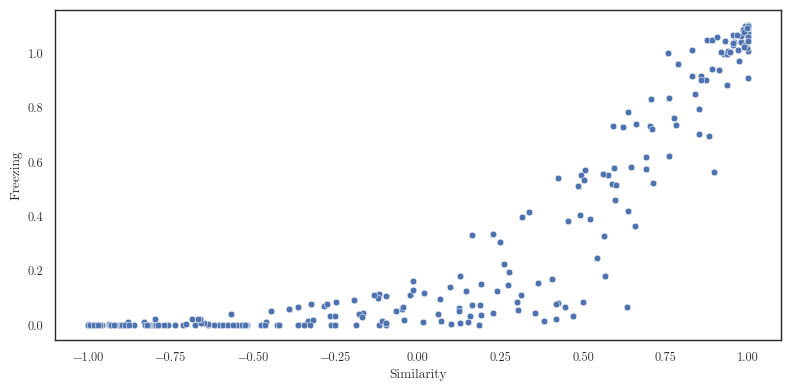

In [64]:
data = run_CS_generalization()

## Experiment 2: Context generalization for fear extinction
After training the CS-US pairing (as in experiment 1), the model will now receive extinction training, then its fear expression will be tested. The CTX applied during conditioning, training, and testing will vary in different experiments, so as to align with the common experimental paradigms.

Unlike in Model 2, we will not set the encoders and intercepts of "external_CTX" to sparsley represent the CTX vectors. Instead, CTX encoders will be randomly distributed around the hypersphere (dimension dim_CTX), and the intercepts will be an independent variable of the experiments (which controls the overlap in neural representations of different contexts.

To ensure that experimental contexts CTX+ and CTX- do not overlap in specific experiments, we will ues a lower-dimensional CTX vector (dim_CTX is small), and we will iteratively sample CTX+ and CTX- from the hypersphere until their similarity is sufficiently low.

In [2]:
class Inputs():
    def __init__(self, nCS=1, nCTX=3, dim_CS=2, dim_CTX=5, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = nengo.dists.UniformHypersphere(surface=True)
        self.dim_CS = dim_CS
        self.dim_CTX = dim_CTX
        self.nCS = nCS
        self.nCTX = nCTX
        self.CS = np.zeros((self.dim_CS))
        self.US = 0
        self.CTX = np.zeros((self.dim_CTX))
        self.CSs = self.sampler.sample(nCS, dim_CS, rng=self.rng)
        self.CTXs = self.sampler.sample(nCTX, dim_CTX, rng=self.rng)
        self.stop_learning = 0  # learning is active by default
    def get_CS(self, t):
        applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
        return self.CS if applied else np.zeros((self.dim_CS))
    def get_CTX(self, t):
        return self.CTX
    def get_US(self, t):
        applied = True if t%2>1 else False # 1s of no input, 1s of US input 
        return self.US if applied else 0
    def get_stop_learning(self, t):
        return self.stop_learning

In [53]:
def build_network_CTX_generalization(
        seed=0,
        learning_rate=1e-4,
        dt=0.001,
        nNeurons=100,
        dim_CS=2,
        dim_CTX=5,
        nCTX=10,
        overlap=0,
    ):

    rng = np.random.RandomState(seed=seed)
    sampler = nengo.dists.UniformHypersphere(surface=True)
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.01
    net.config[nengo.Probe].synapse = 0.01
    net.inputs = Inputs(nCS=1, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, seed=seed)
    intercepts_pos = nengo.dists.Uniform(0, 1)
    encoders_pos = nengo.dists.Choice([[1]])
    encoders_CS = sampler.sample(dim_CS*nNeurons, dim_CS, rng=rng)  # 2D encoders distribted around unit circle
#     intercepts_CTX = nengo.dists.Uniform(-1,1),
#     encoders_CTX = sampler.sample(dim_CTX*nNeurons, dim_CTX, rng=rng)
    encoders_CTX = nengo.dists.Choice(net.inputs.CTXs)
    iCTX = (np.dot(net.inputs.CTXs, net.inputs.CTXs.T) - np.eye(nCTX)).flatten().max()
    overlap_iCTX = iCTX - overlap*(iCTX+1)  # overlap=0 gives perfect separation, overlap=1 gives intercept=-1
    intercepts_CTX = [overlap_iCTX]*dim_CTX*nNeurons

    dInh = -2e0*np.ones((nNeurons, 1))
    
    with net:
        # inputs and outputs
        CS = nengo.Node(lambda t, x: net.inputs.get_CS(t), size_in=2)
        US = nengo.Node(lambda t, x: net.inputs.get_US(t), size_in=2)
        CTX = nengo.Node(lambda t, x: net.inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
        bias = nengo.Node(lambda t: 0.5)
        stop_learning = nengo.Node(lambda t, x: net.inputs.get_stop_learning(t), size_in=2)
        # external ensembles
        external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, encoders=encoders_CS)
        external_US = nengo.Ensemble(nNeurons, 1)
        external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX, intercepts=intercepts_CTX, encoders=encoders_CTX)
#         external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX)
        # amygdala ensembles
        LA_pyr_CS = nengo.Ensemble(nNeurons, 1)  # [CS]
        LA_pyr_US = nengo.Ensemble(nNeurons, 1)  # [US]
        LA_inh_CS = nengo.Ensemble(nNeurons, 1)  # [CS]
        LA_inh_US = nengo.Ensemble(nNeurons, 1)  # [US]
        CeL_on = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [CS]
        CeL_off = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [bias-CS]
        CeM = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        BLA_pyr = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, CTX]
        BLA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
        # error ensembles
        error_LA = nengo.Ensemble(nNeurons, 1)
        error_CeL = nengo.Ensemble(nNeurons, 1)
        error_BLA_safe = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        error_BLA_fear = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        # external connections
        nengo.Connection(CS, external_CS, synapse=None)
        nengo.Connection(US, external_US, synapse=None)
        nengo.Connection(external_CS, LA_inh_CS, function=lambda x: np.sum(np.square(x)))  # any CS present
        nengo.Connection(external_US, LA_inh_US)
        nengo.Connection(external_US, LA_pyr_US)
        nengo.Connection(bias, CeL_off, transform=2)
        nengo.Connection(bias, CeM)
        nengo.Connection(CTX, external_CTX, synapse=None)
        # internal connections
        nengo.Connection(CeL_on, CeL_off, transform=-1)
        nengo.Connection(CeL_off, CeM, transform=-1)
        nengo.Connection(LA_pyr_CS, BLA_pyr[0])  # communicate [CS]
        nengo.Connection(LA_pyr_US, BLA_pyr[1])  # communicate [US]
        nengo.Connection(BLA_pyr[:2], BLA_inh)  # communicate [CS,US]
        nengo.Connection(BLA_pyr[0], CeM, transform=0.3)  # CS response added to freeze response
        nengo.Connection(BLA_pyr[2], CeM, transform=1.0)  # CTX response added to freeze response
        # learned connections
        conditioning = nengo.Connection(external_CS, LA_pyr_CS, function=lambda x: 0, learning_rule_type=nengo.PES(learning_rate))
        transmission = nengo.Connection(LA_pyr_CS, CeL_on, function=lambda x: 0, learning_rule_type=nengo.PES(learning_rate))
        extinction = nengo.Connection(external_CTX, BLA_pyr[2], function=lambda x: 0, learning_rule_type=nengo.PES(0.1*learning_rate))
        # error connections
        nengo.Connection(LA_pyr_US, error_LA, transform=+1)  # US
        nengo.Connection(LA_pyr_CS, error_LA, transform=-1)  # -CS response
        nengo.Connection(LA_pyr_CS, error_CeL, transform=+1)  # LA_pyr_CS response
        nengo.Connection(CeL_on, error_CeL, transform=-1)  # -CeL_on CS response
        nengo.Connection(BLA_pyr, error_BLA_safe, function=lambda x: x[0]+x[2])  # CS response + (-) CTX response
        nengo.Connection(BLA_pyr, error_BLA_fear, function=lambda x: x[1]-x[2])   # US response - CTX response
        # error gating
        nengo.Connection(LA_inh_US, error_LA.neurons, transform=-dInh)  # inhibit if only CS present
        nengo.Connection(LA_inh_CS, error_LA.neurons, transform=+dInh)  # inhibit if only CS present
        nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: 1-x[0]+x[1], transform=dInh)  # inhibit by default; release if CS without US
        nengo.Connection(BLA_inh, error_BLA_fear.neurons, function=lambda x: 1-x[1], transform=dInh)  # inhibit unless US
        nengo.Connection(stop_learning, error_LA.neurons, transform=+dInh)
        nengo.Connection(stop_learning, error_BLA_safe.neurons, transform=+dInh)
        nengo.Connection(stop_learning, error_BLA_fear.neurons, transform=+dInh)
        # error updating
        nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
        nengo.Connection(error_CeL, transmission.learning_rule, transform=-1)
        nengo.Connection(error_BLA_safe, extinction.learning_rule, transform=1)
        nengo.Connection(error_BLA_fear, extinction.learning_rule, transform=-1)

        # probes
        net.pCS = nengo.Probe(CS, synapse=None)
        net.pUS = nengo.Probe(US, synapse=None)
        net.pCTX = nengo.Probe(CTX, synapse=None)
        net.pLA_pyr_CS_spikes = nengo.Probe(LA_pyr_CS.neurons)
        net.pLA_pyr_US_spikes = nengo.Probe(LA_pyr_US.neurons)
        net.pLA_inh_CS_spikes = nengo.Probe(LA_inh_CS.neurons)
        net.pLA_inh_US_spikes = nengo.Probe(LA_inh_US.neurons)
        net.pCeL_on_spikes = nengo.Probe(CeL_on.neurons)
        net.pCeL_off_spikes = nengo.Probe(CeL_off.neurons)
        net.pCeM_spikes = nengo.Probe(CeM.neurons)
        net.pBLA_pyr_spikes = nengo.Probe(BLA_pyr.neurons)
        net.pBLA_inh_spikes = nengo.Probe(BLA_inh.neurons)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pLA_pyr_CS = nengo.Probe(LA_pyr_CS)
        net.pLA_pyr_US = nengo.Probe(LA_pyr_US)
        net.pLA_inh_CS = nengo.Probe(LA_inh_CS)
        net.pLA_inh_US = nengo.Probe(LA_inh_US)
        net.pCeL_on = nengo.Probe(CeL_on)
        net.pCeL_off = nengo.Probe(CeL_off)
        net.pCeM = nengo.Probe(CeM)
        net.pError_LA = nengo.Probe(error_LA)
        net.pError_CeL = nengo.Probe(error_CeL)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pError_BLA_safe = nengo.Probe(error_BLA_safe)
        net.pError_BLA_fear = nengo.Probe(error_BLA_fear)
        
        # save pointers
        net.LA_pyr_CS = LA_pyr_CS
        net.LA_pyr_US = LA_pyr_US
        net.LA_inh_CS = LA_inh_CS
        net.LA_inh_US = LA_inh_US
        net.CeL_on = CeL_on
        net.CeL_off = CeL_off
        net.CeM = CeM
        net.BLA_pyr = BLA_pyr
        net.BLA_inh = BLA_inh
        net.error_LA = error_LA
        net.error_CeL = error_CeL
        net.error_BLA_safe = error_BLA_safe
        net.error_BLA_fear = error_BLA_fear
        
    return net

### 2.1 AAA (control) vs AAB (vary B)
- Phase 1: CS paired with US (5 trials)
- Phase 2: CS paired with no US (10 trials)
- Phase 3: Measure fear expression for a single presentation of CS in CTX B

In [56]:
def run_CTX_generalization_AAB(
        seeds=5,
        nNeurons=100,
        learning_rate_mean=1e-4,
        dt=1e-3,
        nCond=5,
        nExt=10,
        nCTX=3,
        dim_CTX=5,
        overlap=0,
    ):

    data = pd.DataFrame(columns=["seed", "Freezing", "Similarity"])
    rng = np.random.RandomState(seeds)

    for s in range(seeds):
        print(f"seed {s}")
        seed = s
        lr = np.abs(rng.normal(learning_rate_mean, learning_rate_mean/10))
        net = build_network_CTX_generalization(
            seed=seed, learning_rate=lr, nNeurons=nNeurons, nCTX=nCTX, dim_CTX=dim_CTX, overlap=overlap)
        sim = nengo.Simulator(net, dt=dt, progress_bar=False)
        with sim:
            net.inputs.stop_learning = 0  # turn off learning for tests (inhibit all error populations)
            # phase 1
            CTX_A = net.inputs.CTXs[0]
            net.inputs.CS = net.inputs.CSs[0]
            net.inputs.US = 1
            net.inputs.CTX = CTX_A
            for p in range(nCond):
                sim.run(2)
            # phase 1
            net.inputs.CS = net.inputs.CSs[0]
            net.inputs.US = 0
            net.inputs.CTX = CTX_A
            for p in range(nExt):
                sim.run(2)
            # phase 3
            net.inputs.stop_learning = 1  # turn off learning for tests (inhibit all error populations)
            for CTX in range(nCTX):
                print(f"CTX {CTX}")
                CTX_B = net.inputs.CTXs[CTX]
                net.inputs.CS = net.inputs.CSs[0]
                net.inputs.US = 0
                net.inputs.CTX = CTX_B
                sim.run(2)
                freezing = np.mean(sim.data[net.pCeM][-int(1/dt):])
                similarity = np.dot(CTX_A, CTX_B)
                data = data.append({"seed": seed, "Freezing": freezing, "Similarity": similarity}, ignore_index=True)

#         ctx_similarity = np.inner(net.inputs.CTXs[0], sim.data[net.pCTX])
#         fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [1,2,2,1]})
#         axes[0].plot(sim.trange(), sim.data[net.pCeM])
#         axes[0].set(ylabel=r"$\hat{x}$", title="Freezing", yticks=((0,1)))
#         axes[1].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[net.pCS], ord=2, axis=1), label="CS present")
#         axes[1].plot(sim.trange(), 1.5*sim.data[net.pUS], label="US", c='r')
#         axes[1].plot(sim.trange(), ctx_similarity, label="CTX similarity to CTX+")
#         axes[1].legend()
#         axes[1].set(yticks=((1.3,1.5)), ylabel=r"$\hat{x}$", title="Stimuli")
#         axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,2], label="BLA_pyr_CTX")
#         axes[2].legend()
#         axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
#         axes[3].plot(sim.trange(), sim.data[net.pError_BLA_safe], label="CS minus CTX (gated by BLA_inh)")
#         axes[3].plot(sim.trange(), sim.data[net.pError_BLA_fear], label="US minus CTX (gated by BLA_inh)")
#         axes[3].legend()
#         axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
#         plt.tight_layout()

    data.to_pickle("CTX_generalization.pkl")

    fig, ax = plt.subplots(figsize=((8,4)))
    sns.scatterplot(data=data, x='Similarity', y="Freezing", ax=ax)
    ax.set(xlabel="CTX_B Similarity to CTX_A", yticks=((0, 0.2, 0.4, 0.6, 0.8, 1.0 )))
    plt.tight_layout()

    return data

seed 0
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
CTX 5
CTX 6
CTX 7
CTX 8
CTX 9
CTX 10
CTX 11
CTX 12
CTX 13
CTX 14
CTX 15
CTX 16
CTX 17
CTX 18
CTX 19
CTX 20
CTX 21
CTX 22
CTX 23
CTX 24
CTX 25
CTX 26
CTX 27
CTX 28
CTX 29
CTX 30
CTX 31
CTX 32
CTX 33
CTX 34
CTX 35
CTX 36
CTX 37
CTX 38
CTX 39
CTX 40
CTX 41
CTX 42
CTX 43
CTX 44
CTX 45
CTX 46
CTX 47
CTX 48
CTX 49


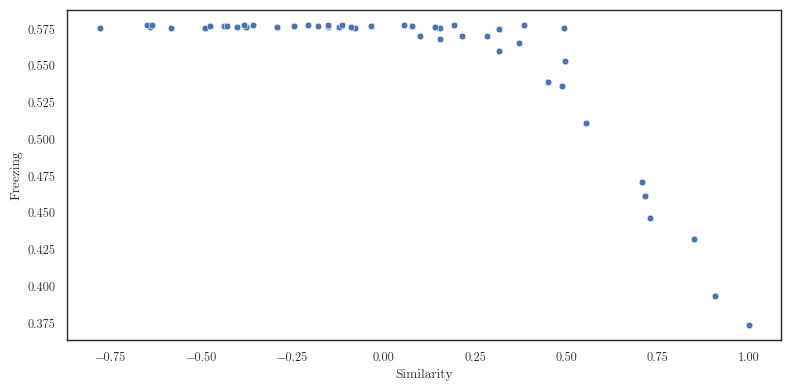

In [57]:
data = run_CTX_generalization_AAB(seeds=1, nCTX=50, overlap=0.2)